In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import copy
from PIL import Image
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
data_root = '/Users/tony/Competitions/data/cleaned_vs_dirty_stepik/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm_notebook(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [5]:
from scipy import ndimage

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [34]:
len(train_dataloader), len(train_dataset)

(5, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


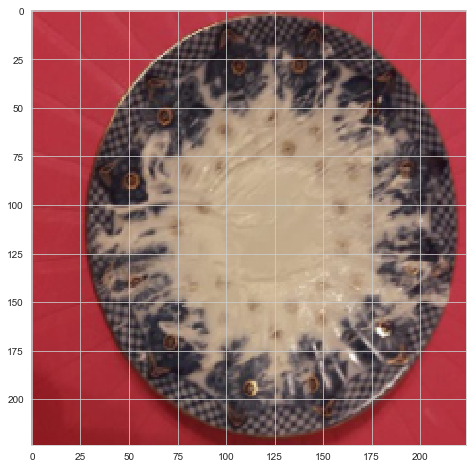

In [35]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [14]:
initial_dataset = []
for target in ['cleaned', 'dirty']:
    for i in os.listdir(os.path.join(data_root, 'train', target))[1:]:
        img = Image.open(os.path.join(data_root, 'train', target, i))
        initial_dataset.append([np.array(img), target])

Сформируем датасет с аугментацией данных (повороты и обрезки)

In [8]:
# Функция для получения обрезанной матрицы
def random_crop_matrix(initial_matrix, crop_sizes=(224, 224)):
    """
    initial_matrix - матрица, которую хотим обрезать
    crop_sizes - два числа (list или tuple) - размеры матрицы на выходе
    """
    
    valid_left_corner = [max(initial_matrix.shape[0] - crop_sizes[0], 0), 
                         max(initial_matrix.shape[1] - crop_sizes[1], 0)]
    sample_left_point = [np.random.randint(0, valid_left_corner[0]), 
                         np.random.randint(0, valid_left_corner[1])]
    resulting_matrix = initial_matrix[sample_left_point[0]: sample_left_point[0]+crop_sizes[0], 
                                      sample_left_point[1]: sample_left_point[1]+crop_sizes[1]]
    return resulting_matrix

In [ ]:
augmented_dataset = []
for i in range(len(initial_dataset)):
    # Сделаем 20 случайных срезок размеров 224x224
    matrix = initial_dataset[i][0]
    tag = initial_dataset[i][1]
    for k in range(20):
        augmented_dataset.append([random_crop_matrix(matrix, crop_sizes=(224, 224)), tag])
# Повернём каждую исходную картинку 72 раза (360/5 градусов)
len_augmented = len(augmented_dataset)
for i in tqdm_notebook(range(len_augmented)):
    matrix = augmented_dataset[i][0]
    tag = augmented_dataset[i][1]
    for angle in range(0, 360, 5):
        augmented_dataset.append(ndimage.rotate(matrix, angle=angle, reshape=False))

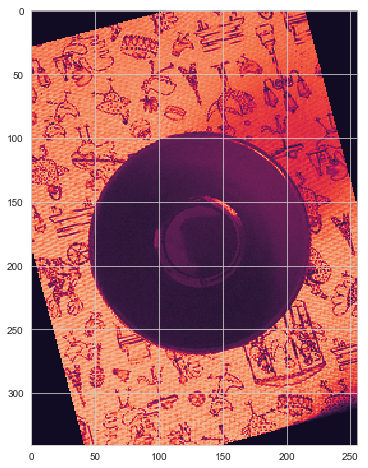

In [677]:
plt.imshow(ndimage.rotate(initial_dataset[0][0][:, :, 0], angle=15, reshape=False))

In [36]:
# def show_input(input_tensor, title=''):
#     image = input_tensor.permute(1, 2, 0).numpy()
#     image = std * image + mean
#     plt.imshow(image.clip(0, 1))
#     plt.title(title, fontsize=20);
#     plt.show()
#     plt.pause(0.001)

# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

In [37]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/tony/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:04<00:00, 9933257.21it/s] 


In [38]:
EPOCHS = 100
DEVICE = 'cpu'
train_loss = []
train_acc = []
val_loss = []
val_acc = []
LEN_TRAIN_DATALOADER = len(train_dataloader)
LEN_VAL_DATALOADER = len(val_dataloader)
for epoch in tqdm_notebook(range(EPOCHS)):
    model.train()
    current_train_loss = 0
    current_train_acc = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        preds = model(inputs)
        loss_value = loss(preds, labels)
#         preds_class = (F.sigmoid(preds) > 0.5)*1.
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
    
        current_train_loss += loss_value.item()
#         current_train_acc += (preds_class.reshape(-1).numpy() == labels.data.numpy()).mean()
        current_train_acc += (preds_class == labels.data).float().mean()
    scheduler.step()
    train_loss.append(current_train_loss / LEN_TRAIN_DATALOADER)
    train_acc.append(current_train_acc / LEN_TRAIN_DATALOADER)
    
    with torch.no_grad():
        model.eval()
        current_val_loss = 0
        current_val_acc = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            preds = model(inputs)
            loss_value = loss(preds, labels)
#             preds_class = (F.sigmoid(preds) > 0.5)*1.
            preds_class = preds.argmax(dim=1)
            current_val_loss += loss_value.item()
#             current_val_acc += (preds_class.reshape(-1).numpy() == labels.data.numpy()).mean()
            current_val_acc += (preds_class == labels.data).float().mean()
        val_loss.append(current_val_loss / LEN_VAL_DATALOADER)
        val_acc.append(current_val_acc / LEN_VAL_DATALOADER)

    print('Epoch: {}'.format(epoch+1), 'train loss: {:.4f}'.format(train_loss[-1]), 'val loss: {:.4f}'.format(val_loss[-1]), 
         'train acc: {:.4f}'.format(train_acc[-1]), 'val acc: {:.4f}'.format(val_acc[-1]))
    

















Epoch: 1 train loss: 0.8697 val loss: 0.6076 train acc: 0.3000 val acc: 0.6667
















Epoch: 2 train loss: 0.7453 val loss: 0.6925 train acc: 0.4750 val acc: 0.6667











Exception in thread Thread-10:
Traceback (most recent call last):
  File "//anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "//anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Epoch: 3 train loss: 0.7102 val loss: 0.5872 train acc: 0.6000 val acc: 0.6667
Epoch: 4 train loss: 0.6422 val loss: 0.6255 train acc: 0.6250 val acc: 0.5000
Epoch: 5 train loss: 0.7580 val loss: 0.5794 train acc: 0.4750 val acc: 0.6667
Epoch: 6 train loss: 0.5449 val loss: 0.6779 train acc: 0.6750 val acc: 0.8333
Epoch: 7 train loss: 0.6031 val loss: 0.6048 train acc: 0.6000 val acc: 0.8333
Epoch: 8 train loss: 0.6495 val loss: 0.6159 train acc: 0.5250 val acc: 0.8333
Epoch: 9 train loss: 0.5393 val loss: 0.5727 train acc: 0.7500 val acc: 0.8333
Epoch: 10 train loss: 0.5885 val loss: 0.5552 train acc: 0.6000 val acc: 0.6667
Epoch: 11 train loss: 0.6133 val loss: 0.5629 train acc: 0.5750 val acc: 0.6667
Epoch: 12 train loss: 0.6111 val loss: 0.5200 train acc: 0.6250 val acc: 0.6667
Epoch: 13 train loss: 0.5124 val loss: 0.5488 train acc: 0.7750 val acc: 0.6667
Epoch: 14 train loss: 0.5895 val loss: 0.5527 train acc: 0.7250 val acc: 0.6667
Epoch: 15 train loss: 0.4876 val loss: 0.5508 t

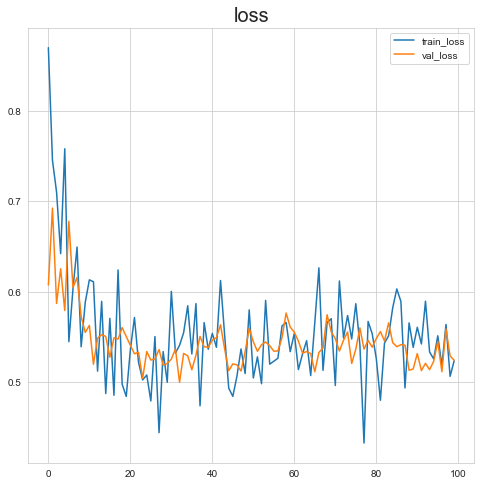

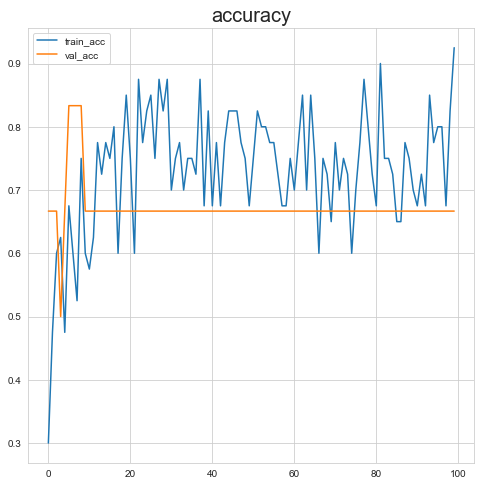

In [40]:
plt.figure(figsize=(8, 8))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend();
plt.title('loss', fontsize=20);

plt.figure(figsize=(8, 8))
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend();
plt.title('accuracy', fontsize=20);

In [58]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [59]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=-1)

In [61]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm_notebook(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

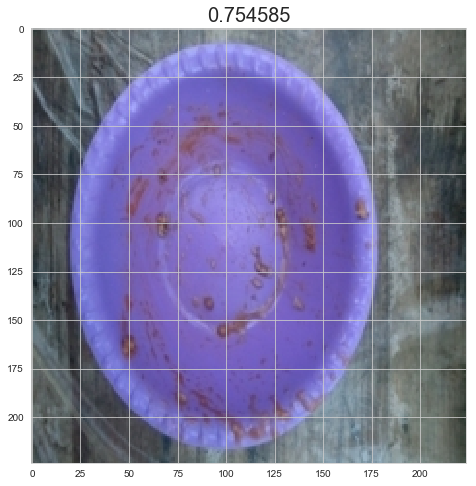

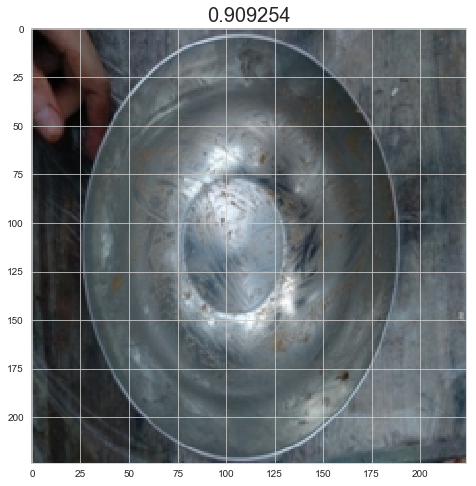

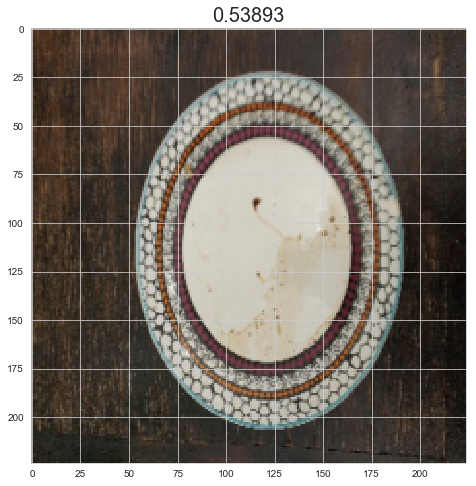

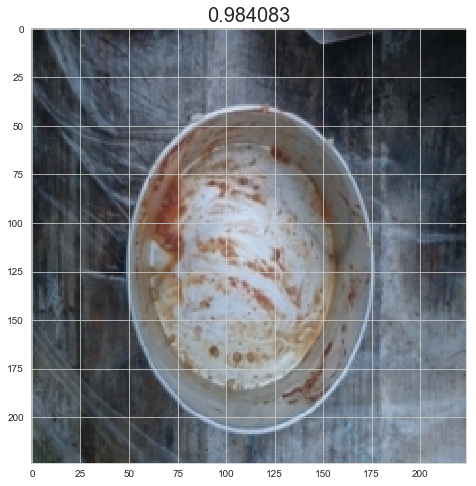

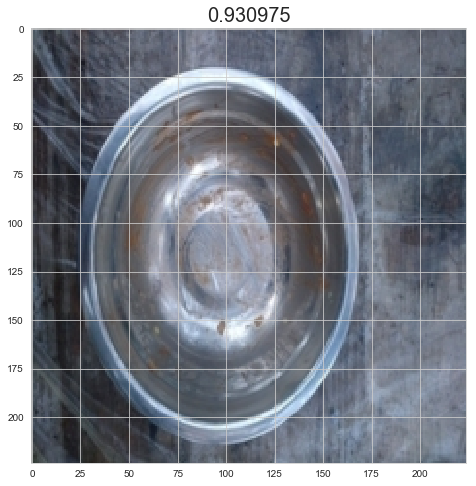

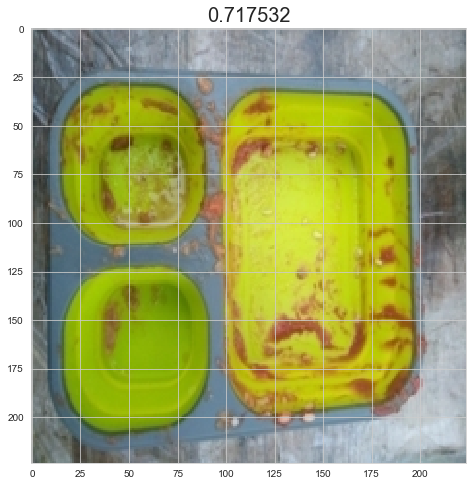

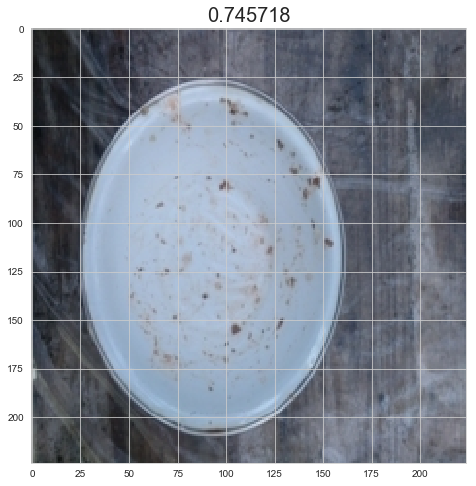

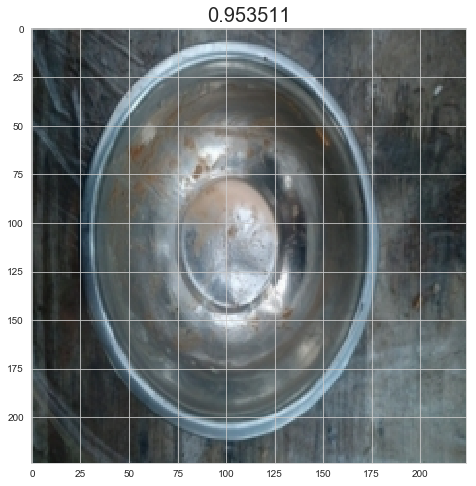

In [62]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [63]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [65]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [66]:
submission_df.to_csv('/Users/tony/Desktop/submission_clean_dirty.csv')